In [1]:
import numpy as np
from sklearn import linear_model
import scipy.misc
from matplotlib import pyplot as plt
import cv2

In [20]:
class KSVD(object):
    def __init__(self, n_components=512, max_iter=30, tol=1e-6,
                 n_nonzero_coefs=None):
        """
        稀疏模型Y = DX，Y为样本矩阵，使用KSVD动态更新字典矩阵D和稀疏矩阵X
        :param n_components: 字典所含原子个数（字典的列数）
        :param max_iter: 最大迭代次数
        :param tol: 稀疏表示结果的容差
        :param n_nonzero_coefs: 稀疏度
        """
        self.dictionary = None
        self.sparsecode = None
        self.max_iter = max_iter
        self.tol = tol
        self.n_components = n_components
        self.n_nonzero_coefs = n_nonzero_coefs

    def _initialize(self, y):
        """
        用随机二阶单位范数初始化字典矩阵
        """
        shape=[64,self.n_components]
        #对每一列归一化为L2-norm
        self.dictionary = np.random.random(shape)
        for i in range(shape[1]):
            self.dictionary[:, i]=self.dictionary[:, i]/np.linalg.norm(self.dictionary[:, i])

    def _update_dict(self, y, d, x):
        """
        使用KSVD更新字典的过程
        """
        for i in range(self.n_components):
            index = np.nonzero(x[i, :])[0]
            if len(index) == 0:
                continue
            d[:, i] = 0
            r = (y - np.dot(d, x))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            d[:, i] = u[:, 0].T
            x[i, index] = s[0] * v[0, :]
        
        self.sparsecode = x
        return d, x


    def fit(self, img):
        """
        KSVD迭代过程
        """
        #以防图片不是256*256，先进行一reshape
        img=cv2.resize(img,(256,256),img)
        print(img.shape, type(img))

        #将图像按8*8的块转化列向量，合起来成为64*1024的矩阵
        #img保存原始图像转化的矩阵，y用于保存img减去列均值后的矩阵
        y=np.zeros((8*8, 32*32))
        img_reshape=np.zeros((8*8, 32*32))

        patch_num=1024
        
        for patch_index in range(patch_num):
            #按先行后列，将图片分解成32*32个8*8的小块并装换为列向量
            r=int(int(patch_index/32)*8)
            c=int(int(patch_index%32)*8)
            patch=img[r:r+8, c:c+8].flat
            #normalize=np.linalg.norm(patch)
            #mean=np.sum(patch)/64
            #print mean
            img_reshape[:, patch_index]=patch
            #y[:, patch_index]=(patch/mean)
            y[:, patch_index]=patch-mean*np.ones(64))/normalize
            #y[:, patch_index]=(patch-mean*np.ones(64))/normalize

        #字典初始化
        self._initialize(y)

        for i in range(self.max_iter):
            #linear_model.orthogonal_mp 用法详见：
            #http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.orthogonal_mp.html
            x = linear_model.orthogonal_mp(self.dictionary, y, n_nonzero_coefs=self.n_nonzero_coefs)#OMP
            e = np.linalg.norm(y- np.dot(self.dictionary, x))
            print('第%s次迭代，误差为：%s' %(i, e))
            if e < self.tol:
                break
            self._update_dict(y, self.dictionary, x)

        #
        src_rec=np.zeros(img.shape)
        for patch_index in range(patch_num):
            x = linear_model.orthogonal_mp(self.dictionary, y[:, patch_index], n_nonzero_coefs=self.n_nonzero_coefs)
            #x = linear_model.orthogonal_mp(self.dictionary, img_reshape[:, patch_index], n_nonzero_coefs=self.n_nonzero_coefs)
            nomalize=np.linalg.norm(img_reshape[:, patch_index])
            mean=np.sum(img_reshape[:, patch_index])/64
            #patch=np.dot(self.dictionary, x)+mean*np.ones(64)
            patch=np.dot(self.dictionary, x)*nomalize+mean*np.ones(64)
            r=int(int(patch_index/32)*8)
            c=int(int(patch_index%32)*8)
            src_rec[r:r+8, c:c+8]=patch.reshape((8,8))

        return self.dictionary, src_rec, self.sparsecode

    def missing_pixel_reconstruct(self, img):
        img_patchs=img_to_patch(img)
        patch_num=img_patchs.shape[1]
        #patch_dim=img_patchs.shape[0]
        for i in range(patch_num):
            img_col=img_patchs[:, i]
            index = np.nonzero(img_col)[0]
            #对每列去掉丢失的像素值后求平均、二阶范数，将其归一化
            l2norm=np.linalg.norm(img_col[index])
            mean=np.sum(img_col)/index.shape[0]
            img_col_norm=(img_col-mean)/l2norm
            x = linear_model.orthogonal_mp(self.dictionary[index, :], img_col_norm[index].T, n_nonzero_coefs=self.n_nonzero_coefs)
            img_patchs[:, i]=(self.dictionary.dot(x)*l2norm)+mean

        return patch_to_img(img_patchs)

In [21]:
def pixel_miss(ori,per=0.3):
    img=ori.copy()
    shape=img.shape
    #rand=np.random.random(shape)
    n=int(per*shape[0]*shape[1])
    for i in range(n):
        rand_r=int(np.random.random()*shape[0])
        rand_c=int(np.random.random()*shape[1])
        img[rand_r, rand_c]=0
    return img

#高斯噪点
def Gauss_noise(ori,sigma=20):
    #sigma=np.sqrt(sigma)
    img=ori.copy().astype(np.float64)
    shape=img.shape
    img=img+(np.matlib.randn(shape))*sigma
    return img.astype(np.uint8)

#计算PSNR值
def psnr(A, B):
    if (A==B).all(): return 0
    return 10*np.log10(255*255.0/(((A.astype(np.float)-B)**2).mean()))

#将8*8块为列向量的矩阵还原为原矩阵
def patch_to_img(patchs):
    patch_num=patchs.shape[1]
    size=np.sqrt(patch_num).astype(np.int)
    patch_size=np.sqrt(patchs.shape[0]).astype(np.int)
    img=np.zeros((patch_size*size, patch_size*size))
    for i in range(patch_num):
        r=int(int(i/size)*8)
        c=int(int(i%size)*8)
        img[r:r+8, c:c+8]=patchs[:, i].reshape((8, 8))
    return img

#将图像分割为8*8块作为列向量
def img_to_patch(img):
    patchs=np.zeros((8*8, 32*32))
    blocks_r=img.shape[0]/8
    blocks_c=img.shape[1]/8
    patch_num=blocks_r*blocks_c
    for i in range(patchs.shape[1]):
        #按先行后列，将图片分解成32*32个8*8的小块并装换为列向量
        r=int(int(i/blocks_r)*8)
        c=int(int(i%blocks_c)*8)
        patch=img[r:r+8, c:c+8].flat
        patchs[:, i]=patch
    return patchs

In [22]:
#读入原图
ori = cv2.imread("./images/aa1.png",0).astype(np.uint8)
#像素丢失后的图
img=pixel_miss(ori)

In [23]:
#训练字典所用的图
train = cv2.imread("./images/aa1.png",0).astype(np.uint8)

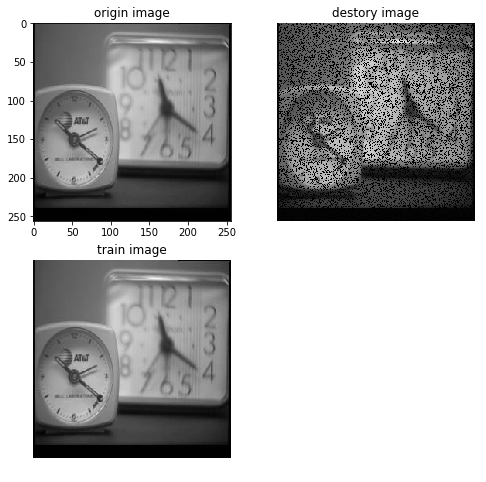

破坏像素点后图像PSNR值： 13.131795135549202


In [24]:
#展示原图、破坏图、训练用图
plt.figure(num='astronaut',figsize=(8,8))

plt.subplot(2,2,1) #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('origin image') #第一幅图片标题
plt.imshow(ori.astype(np.uint8), plt.cm.gray) #绘制第一幅图片

plt.subplot(2,2,2) #第二个子图
plt.title('destory image') #第二幅图片标题
plt.imshow(img.astype(np.uint8), plt.cm.gray) #绘制第二幅图片,且为灰度图
plt.axis('off') #不显示坐标尺寸

plt.subplot(2,2,3) #第二个子图
plt.title('train image') #第二幅图片标题
plt.imshow(train.astype(np.uint8), plt.cm.gray) #绘制第二幅图片,且为灰度图
plt.axis('off') #不显示坐标尺寸

plt.show()

print('破坏像素点后图像PSNR值：', psnr(ori, img))

In [25]:
#最大迭代次数设为20
ksvd = KSVD(max_iter=2)
dictionary, src_rec,x = ksvd.fit(train)

(256, 256) <class 'numpy.ndarray'>
第0次迭代，误差为：7.138175434789368
第1次迭代，误差为：6.595320849638162


(64, 512)
(512, 1024)


83.10774342626749

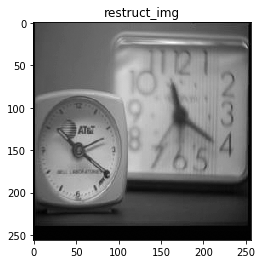

In [27]:
print(dictionary.shape)
print(x.shape)
restruct = dictionary.dot(x)
#print(restruct)
#restruct = restruct*255
restruct_img = patch_to_img(restruct)
#print(restruct_img)
plt.title('restruct_img') #第二幅图片标题
plt.imshow(restruct_img.astype(np.uint8), plt.cm.gray) #绘制第二幅图片,且为灰度图
psnr(train ,restruct_img)

(64, 1024)


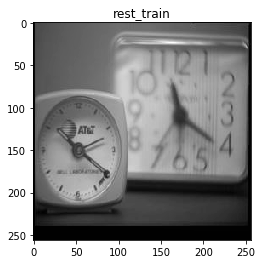

In [23]:
train_patches = img_to_patch(train)
print(train_patches.shape)
rest_train = patch_to_img(train_patches)
plt.title('rest_train') #第二幅图片标题
plt.imshow(rest_train.astype(np.uint8), plt.cm.gray) #绘制第二幅图片,且为灰度图

(256, 256) <class 'numpy.ndarray'>


/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


第0次迭代，误差为：4.967029531165825


/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarn

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00776784 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarn

/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)
/home/noopyxu/.conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/omp.py:387: RuntimeWarn

利用训练获得的字典重构图像后PSNR值： 32.753129380971366
用字典重构训练集合信号PSNR： 33.676079662950144
字典还原原图： 33.676079662950144


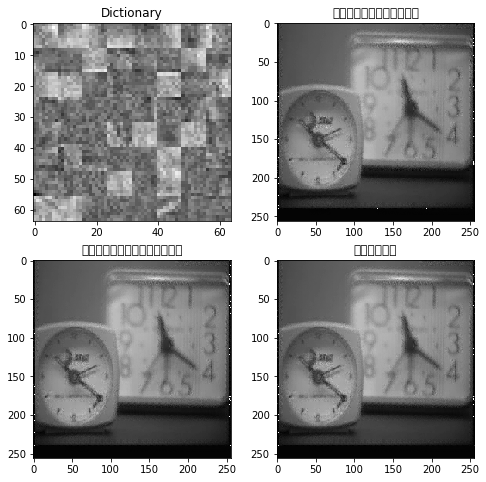

In [40]:
#最大迭代次数设为80
ksvd = KSVD(max_iter=1)
dictionary, src_rec,x = ksvd.fit(train)

print(x.shpae)

#按块展示字典
#cv2.namedWindow("Dictionary")

dictionary=dictionary-np.amin(dictionary)
dictionary=dictionary/np.amax(dictionary)

#cv2.imshow("Dictionary", patch_to_img(dictionary))#.astype(np.uint8))


plt.figure(num='astronaut',figsize=(8,8))

plt.subplot(2,2,1)
plt.title(u'Dictionary')
plt.imshow(patch_to_img(dictionary), plt.cm.gray)

#用训练得到的字典还原图像
#cv2.namedWindow("K-SVD_Rec")
img=ksvd.missing_pixel_reconstruct(img)
#字典还原原图
aaimg = ksvd.missing_pixel_reconstruct(ori)
plt.subplot(2,2,2)
plt.title(u'用训练得到的字典还原图像')
plt.imshow(img.astype(np.uint8), plt.cm.gray)
#cv2.imshow("K-SVD_Rec", img.astype(np.uint8))
print('利用训练获得的字典重构图像后PSNR值：', psnr(ori, img))

#用训练得到的字典还原训练用图
plt.subplot(2,2,3)
plt.title(u'用训练得到的字典还原训练用图')
plt.imshow(src_rec.astype(np.uint8), plt.cm.gray)
#cv2.namedWindow("K-SVD")
#cv2.imshow("K-SVD",src_rec.astype(np.uint8))
print('用字典重构训练集合信号PSNR：', psnr(train,src_rec))

#用训练得到的字典还原训练用图
plt.subplot(2,2,4)
plt.title(u'字典还原原图')
plt.imshow(aaimg.astype(np.uint8), plt.cm.gray)
#cv2.namedWindow("K-SVD")
#cv2.imshow("K-SVD",src_rec.astype(np.uint8))
print('字典还原原图：', psnr(ori,aaimg))

In [1]:
print(dictionary.shape)

NameError: name 'dictionary' is not defined

In [ ]:
print('字典还原原图：', psnr(aaimg,aaimg))

In [ ]:
print(src_rec.size())

In [ ]:
plt.imshow(aaimg.astype(np.uint8), plt.cm.gray)

In [ ]:
plt.imshow(src_rec.astype(np.uint8), plt.cm.gray)